In [10]:
%load_ext autoreload
%autoreload 2

import sys
if sys.path[-1] != "..": sys.path.append("..")

from qBN.qBNMC import qBayesNet
from qBN.qBNRejection import qInference
from XPs.qBNRT import qRuntime

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import matplotlib.pyplot as plt

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33'
)

backend = service.get_backend("ibm_brisbane")

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='1b6910ff55c1d3853e5c8e2ca2b0dbbc3b415fb897d26a6c272c63254527581c824aea1180585f706ab8263318f3c553549d136ca32952ef401abb54011eee33')

In [11]:
bn1 = gum.fastBN("A->B<-C", 2)
bn1.cpt("A")[:] = [0.05, 0.95]
bn1.cpt("C")[:] = [0.05, 0.95]
bn1.cpt("B")[:] = [[[0.1, 0.9], [0.2, 0.8]], [[0.3, 0.7], [0.4, 0.6]]]
qbn1 = qBayesNet(bn1)

In [12]:
ev1 = {"A": 0, "C":0}
tn1 = "B"
value_range = range(100,1001,100)

In [13]:
qinf1 = qInference(qbn1)
qinf1.setEvidence(ev1)
qinf1.useFragmentBN(target={tn1})
qinf1.getGates()

In [14]:
ie1 = gum.LazyPropagation(bn1)
ie1.setEvidence(ev1)
ie1.makeInference()

In [15]:
nb_obs = 1

In [17]:
mc1_max_err = list()

for j in range(nb_obs):
    mc1_max_err.append(list())
    for i in value_range:

        mc1 = gum.MonteCarloSampling(bn1)
        mc1.setEvidence(ev1)
        mc1.setEpsilon(1e-10)
        mc1.setMaxTime(1e10)
        mc1.setMaxIter(i)
        mc1.makeInference()

        offset = mc1.posterior(tn1).toarray() - ie1.posterior(tn1).toarray()
        max_offset = offset.max()
        mc1_max_err[j].append(max_offset)

mc1_max_err = np.array(mc1_max_err)

In [18]:
qinf1_max_err = list()

for j in range(nb_obs):
    qinf1_max_err.append(list())
    print(f"Run number {j} -", end=' ')
    for i in value_range:

        qinf1.setMaxIter(i)
        qinf1.makeInference()

        offset = qinf1.posterior(tn1).toarray() - ie1.posterior(tn1).toarray()
        max_offset = offset.max()
        qinf1_max_err[j].append(max_offset)

        print(f"{i}: {max_offset:.4f}", end=', ')
    print()

qinf1_max_err = np.array(qinf1_max_err)

Run number 0 - 100: 0.0200, 200: 0.0050, 300: 0.0433, 400: 0.0275, 500: 0.0020, 600: 0.0083, 700: 0.0000, 800: 0.0162, 900: 0.0067, 


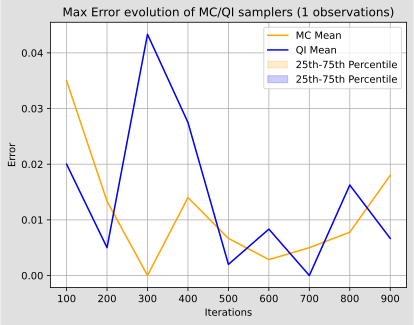

In [19]:
mc1_mean = np.mean(mc1_max_err, axis=0)
mc1_percentile_25 = np.percentile(mc1_max_err, 25, axis=0)
mc1_percentile_75 = np.percentile(mc1_max_err, 75, axis=0)

qinf1_mean = np.mean(qinf1_max_err, axis=0)
qinf1_percentile_25 = np.percentile(qinf1_max_err, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf1_max_err, 75, axis=0)


plt.plot(value_range, mc1_mean, label='MC Mean', color='orange')
plt.plot(value_range, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(value_range, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(value_range, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title(f'Max Error evolution of MC/QI samplers ({nb_obs} observations)')
plt.legend()
plt.grid(True)

plt.savefig('ErrEvoIter.png')
plt.show()

In [20]:
qrt1 = qRuntime(qinf1, backend)
qrt1.getGateExecutionTime()
A_time = qrt1.A_time
G_time = qrt1.G_time

In [21]:
nb_obs = 1

In [22]:
mc1_time = list()

for j in range(nb_obs):
    mc1_time.append(list())
    for i in value_range:

        mc1 = gum.MonteCarloSampling(bn1)
        mc1.setEvidence(ev1)
        mc1.setEpsilon(1e-10)
        mc1.setMaxTime(1e10)
        mc1.setMaxIter(i)
        mc1.makeInference()

        mc1_time[j].append(mc1.currentTime())

mc1_time = np.array(mc1_time)

In [23]:
qinf1_time = list()

for j in range(nb_obs):
    qinf1_time.append(list())
    print(f"Run number {j} -", end=' ')
    for i in value_range:

        qinf1.setMaxIter(i)
        qinf1.makeInference()

        qrt = qRuntime(qinf1, backend)
        qrt.A_time = A_time
        qrt.G_time = G_time

        run_time = qrt.rejectionSamplingRuntime()
        qinf1_time[j].append(run_time)

        print(f"{i}: {run_time:.4f}", end=', ')
    print()

qinf1_time = np.array(qinf1_time)

Run number 0 - 100: 0.3642, 200: 1.2127, 300: 1.1772, 400: 1.5848, 500: 1.9301, 600: 2.8047, 700: 2.8898, 800: 3.1585, 900: 3.5248, 


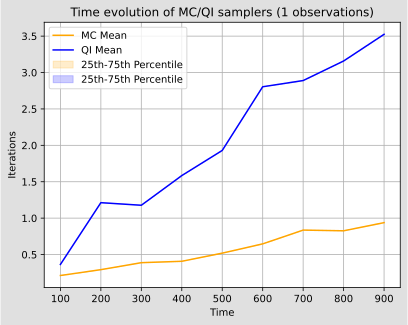

In [24]:
mc1_mean = np.mean(mc1_time, axis=0)
mc1_percentile_25 = np.percentile(mc1_time, 25, axis=0)
mc1_percentile_75 = np.percentile(mc1_time, 75, axis=0)

qinf1_mean = np.mean(qinf1_time, axis=0)
qinf1_percentile_25 = np.percentile(qinf1_time, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf1_time, 75, axis=0)


plt.plot(value_range, mc1_mean, label='MC Mean', color='orange')
plt.plot(value_range, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(value_range, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(value_range, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Time')
plt.ylabel('Iterations')
plt.title(f'Time evolution of MC/QI samplers ({nb_obs} observations)')
plt.legend()
plt.grid(True)

plt.savefig('TimeEvoIter.png')
plt.show()

In [34]:
value_range = range(2000, 10001 ,2000)
nb_obs = 1
iter = 100

In [35]:

qinf_run_time_list = list()
qinf_proba_err_list = list()

for j in range(nb_obs):

    qinf_run_time_list.append(list())
    qinf_proba_err_list.append(list())

    for i in value_range:
        bn = gum.fastBN("A->B<-C", 2)
        bn.cpt("C")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("A")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("B")[:] = [[[0.3,0.7],[0.4,0.6]],[[0.5,0.5],[0.6,0.4]]]
        evidence = {"A": 0, "C": 0}
        target = "B"

        ie = gum.LazyPropagation(bn)
        ie.setEvidence(evidence)
        ie.makeInference()

        qbn = qBayesNet(bn)

        qinf = qInference(qbn)
        qinf.setEvidence(evidence)
        qinf.getGates()
        qinf.setMaxIter(iter)
        qinf.makeInference()

        qrt = qRuntime(qinf, backend)
        run_time = qrt.rejectionSamplingRuntime()

        error = (qinf.posterior(target).toarray() - ie.posterior(target).toarray()).max()

        print(f"i: {i}, P(e): {ie.evidenceProbability():.10f}, log: {qinf.log}, runtime: {run_time:.5f}, error: {error}")

        qinf_run_time_list[j].append(run_time)
        qinf_proba_err_list[j].append(error)

qinf_run_time_list = np.array(qinf_run_time_list)
qinf_proba_err_list = np.array(qinf_proba_err_list)

i: 2000, P(e): 0.0005000000, log: {'A': 516, 'G': 3702}, runtime: 0.93771, error: 0.04000000000000015
i: 4000, P(e): 0.0002500000, log: {'A': 580, 'G': 6444}, runtime: 1.57813, error: 0.02000000000000013
i: 6000, P(e): 0.0001666667, log: {'A': 621, 'G': 7579}, runtime: 1.85018, error: 0.0700000000000005
i: 8000, P(e): 0.0001250000, log: {'A': 652, 'G': 10372}, runtime: 2.50994, error: 0.0600000000000005
i: 10000, P(e): 0.0001000000, log: {'A': 644, 'G': 9980}, runtime: 2.44815, error: 0.0600000000000005


In [36]:
mc_run_time_list = list()
mc_proba_err_list = list()

ev_proba_list = list()

for j in range(nb_obs):

    mc_run_time_list.append(list())
    mc_proba_err_list.append(list())
    ev_proba_list.append(list())

    for i in value_range:
        bn = gum.fastBN("A->B<-C", 2)
        bn.cpt("C")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("A")[:] = [i**(-1/2), 1-i**(-1/2)]
        bn.cpt("B")[:] = [[[0.3,0.7],[0.4,0.6]],[[0.5,0.5],[0.6,0.4]]]
        evidence = {"A": 0, "C": 0}
        target = "B"

        ie = gum.LazyPropagation(bn)
        ie.setEvidence(evidence)
        ie.makeInference()

        mc = gum.MonteCarloSampling(bn)

        mc.setEvidence(evidence)
        mc.setEpsilon(1e-10)
        mc.setMaxTime(1e10)
        mc.setMaxIter(iter)
        mc.makeInference()

        run_time = mc.currentTime()

        error = (mc.posterior(target).toarray() - ie.posterior(target).toarray()).max()

        print(f"i: {i}, P(e): {ie.evidenceProbability():.10f}, runtime: {run_time:.5f}, error: {error}")

        mc_run_time_list[j].append(run_time)
        mc_proba_err_list[j].append(error)

        ev_proba_list[j].append(ie.evidenceProbability())

ev_proba_list = ev_proba_list[0]

mc_run_time_list = np.array(mc_run_time_list)
mc_proba_err_list = np.array(mc_proba_err_list)

i: 2000, P(e): 0.0005000000, runtime: 1.08498, error: 0.04500000000000004
i: 4000, P(e): 0.0002500000, runtime: 2.03825, error: 0.030000000000000027
i: 6000, P(e): 0.0001666667, runtime: 2.92721, error: 0.0050000000000000044
i: 8000, P(e): 0.0001250000, runtime: 3.90437, error: 0.030000000000000027
i: 10000, P(e): 0.0001000000, runtime: 4.76407, error: 0.015000000000000013


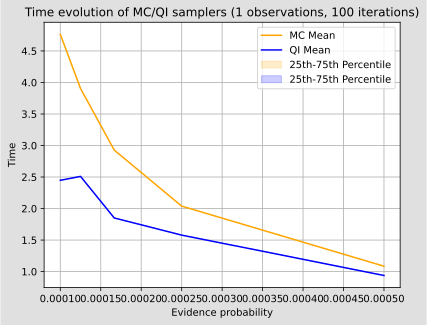

In [37]:
mc1_mean = np.mean(mc_run_time_list, axis=0)
mc1_percentile_25 = np.percentile(mc_run_time_list, 25, axis=0)
mc1_percentile_75 = np.percentile(mc_run_time_list, 75, axis=0)

qinf1_mean = np.mean(qinf_run_time_list, axis=0)
qinf1_percentile_25 = np.percentile(qinf_run_time_list, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf_run_time_list, 75, axis=0)

plt.plot(ev_proba_list, mc1_mean, label='MC Mean', color='orange')
plt.plot(ev_proba_list, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(ev_proba_list, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(ev_proba_list, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Evidence probability')
plt.ylabel('Time')
plt.title(f'Time evolution of MC/QI samplers ({nb_obs} observations, {iter} iterations)')
plt.legend()
plt.grid(True)

plt.savefig('TimeEvoProb.png')
plt.show()

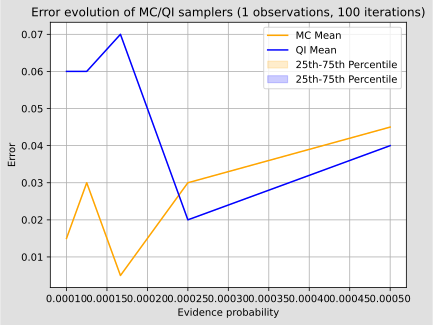

In [38]:
mc1_mean = np.mean(mc_proba_err_list, axis=0)
mc1_percentile_25 = np.percentile(mc_proba_err_list, 25, axis=0)
mc1_percentile_75 = np.percentile(mc_proba_err_list, 75, axis=0)

qinf1_mean = np.mean(qinf_proba_err_list, axis=0)
qinf1_percentile_25 = np.percentile(qinf_proba_err_list, 25, axis=0)
qinf1_percentile_75 = np.percentile(qinf_proba_err_list, 75, axis=0)

plt.plot(ev_proba_list, mc1_mean, label='MC Mean', color='orange')
plt.plot(ev_proba_list, qinf1_mean, label='QI Mean', color='blue')

plt.fill_between(ev_proba_list, mc1_percentile_25, mc1_percentile_75, color='orange', alpha=0.2, label='25th-75th Percentile')
plt.fill_between(ev_proba_list, qinf1_percentile_25, qinf1_percentile_75, color='blue', alpha=0.2, label='25th-75th Percentile')

plt.xlabel('Evidence probability')
plt.ylabel('Error')
plt.title(f'Error evolution of MC/QI samplers ({nb_obs} observations, {iter} iterations)')
plt.legend()
plt.grid(True)

plt.savefig('ErrEvoProb.png')
plt.show()